In [1]:
%matplotlib inline
from __future__ import division

In [2]:
import os
import sys
import urllib
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
sys.path.append('../../src')
from features import SearchFeatures

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
pd.options.display.max_columns = 999

FLYR is the world’s premier machine learning and data company in the flight and travel pricing space. Better than anybody else, we understand where people want to travel, how much they want to pay and how the prices currently available will change over time. Still, there is a lot more that we can improve upon and a lot more data that we have yet to tap into. The success of the products that we can offer to consumers, online travel companies and airlines is largely driven by our ability to measure and predict the “market value” of a flight being offered to potential travelers and the travelers’ willingness to accept the offered airfare.
The data and prediction challenges confronted in travel and pricing are both complex and nebulous. Most of the time there are multiple steps to the problem and multiple considerations that must be balanced at the same time while working toward a goal that is not fully defined. Below is a simplified, although certainly not simple, example of the challenges we face daily.
In this challenge there are two goals.
1. Use the attached data sets to build a model that predicts an offered airfare. The decisions on how which data points you use to validate your model and which metrics you choose to optimize and use to report your findings are left to you, but please clearly communicate both the results, methodology, assumptions and reasons for these decisions in your final report.
2. Use the attached data sets to predict which airfares are ultimately booked.  Again, you are free to choose the simplifications, methodologies and metrics that you feel are appropriate and are most comfortable with.

Search Data
 * search_id - Unique id for the search.
 * search_time - UTC timestamp of search.
 * currency - 3-letter currency code of the airfare.
 * destination - 3-letter airport code of the destination airport.
 * search_user_id - FLYR’s unique user ID.
 * language - Language in which the search was done.
 * origin -  3-letter airport code of the origin airport.
 * partner_id - FLYR’s anonymized ID for a partnering travel website.
 * passengers - Number of passengers in the flight search.
 * pos - Point of Sale, country to which the airfare is being offered.
 * session_id - Unique identifier of a search session.
 * user_agent - Web browser user agent.
 * num_requests - The number of flight itineraries in the search results as seen by FLYR.
 * fare - The airfare offered.
 * supplier - FLYR’s anonymized ID for a airfare supplier to the travel website.
 * cabin_class - cabin class of the flight search.
 * carrier_1 - The two letter airline code of the outbound flight itinerary. If there are multiple
flight segments then the carrier codes are separated by semicolons.
 * carrier_2 - The two letter airline code of the inbound flight itinerary. If there are multiple
flight segments then the carrier codes are separated by semicolons.
 * flight_num_1 - The flight numbers of the outbound flight itinerary. If there are multiple
flight segments then the carrier codes are separated by semicolons.
 * flight_num_2 - The flight numbers of the inbound flight itinerary. If there are multiple
flight segments then the carrier codes are separated by semicolons.
 * departure_datetime_1 - Departure datetime for each flight segment of the outbound
flight itinerary localized to departure airport.
 * departure_datetime_2 - Departure datetime for each flight segment of the inbound flight
itinerary localized to departure airport.
 * arrival_datetime_1 - Arrival datetime for each flight segment of the outbound flight
itinerary localized to arrival airport.
 * arrival_datetime_2 - Arrival datetime for each flight segment of the inbound flight
itinerary localized to arrival airport.
 * itinerary_id - Unique ID for an offered flight itinerary.
 
Booking Data
 * booking_id - Unique ID for the search
 * booking_time - UTC timestamp of booking.
 * currency - 3-letter currency code of the airfare.
 * destination - 3-letter airport code of the destination airport.
 * search_user_id - FLYR’s unique user ID. language - Language in which the search was done.
 * origin -  3-letter airport code of the origin airport.
 * partner_id - FLYR’s anonymized ID for a partnering travel website.
 * passengers - Number of passengers in the flight search.
 * pos - Point of Sale, country to which the airfare is being offered.
 * session_id - Unique identifier of a search session.
 * user_agent - Web browser user agent.
 * num_requests - The number of flight itineraries in the search results as seen by FLYR.
 * fare - The airfare offered.
 * supplier - FLYR’s anonymized ID for a airfare supplier to the travel website.
 * cabin_class - cabin class of the flight search.
 * carrier_1 - The two letter airline code of the outbound flight itinerary. If there are multiple
flight segments then the carrier codes are separated by semicolons.
 * carrier_2 - The two letter airline code of the inbound flight itinerary. If there are multiple
flight segments then the carrier codes are separated by semicolons.
 * flight_num_1 - The flight numbers of the outbound flight itinerary. If there are multiple
flight segments then the carrier codes are separated by semicolons.
 * flight_num_2 - The flight numbers of the inbound flight itinerary. If there are multiple
flight segments then the carrier codes are separated by semicolons.
 * departure_datetime_1 - Departure datetime for each flight segment of the outbound
flight itinerary localized to departure airport.
 * departure_datetime_2 - Departure datetime for each flight segment of the inbound flight
itinerary localized to departure airport.
 * arrival_datetime_1 - Arrival datetime for each flight segment of the outbound flight
itinerary localized to arrival airport.
 * arrival_datetime_2 - Arrival datetime for each flight segment of the inbound flight
itinerary localized to arrival airport.
 * itinerary_id - Unique ID for an offered flight itinerary.
 
Airport Data
 * iata_code - 3-letter IATA airport code.
 * city - The name of the city served by the airport, if known.
 * country - The name of the country in which the airport is located.
 * latitude - Latitude of the airport, if known.
 * longitude - Longitude of the airport, if known.
 * altitude - Altitude of the airport, if known.
 * timezone - Local timezone for the airport.
 * dst - Daylight saving time rules for the airport.
 * aggregate_code - 1 if the code is for multiple airports in a metropolitan area. 0 if the
code is for a specific airport.


In [5]:
class FlyrData:
    
    @staticmethod
    def __maybe_download(url, filename, download_dir='.downloaded_files'):
        
        def dlProgress(count, blockSize, totalSize):
            percent = int(count*blockSize*100/totalSize)
            sys.stdout.write("\rDownloading: " + filename + "...%d%%" % min(percent, 100))
        
        link = url.strip()
        filename = os.path.join(download_dir, filename)                

        try:
            os.stat(download_dir)
        except:
            os.mkdir(download_dir)
        if not os.path.isfile(filename):
            try:
                urllib.request.urlretrieve(link, filename, reporthook=dlProgress)
                print(' done.')
            except Exception as inst:
                os.remove(filename)
                print(inst)        
        try:
            with gzip.open(filename) as f:
                return pd.read_csv(f)
        except Exception as inst:
            os.remove(filename)
            print(inst)
    
    def __init__(self):
        self.bookings = FlyrData.__maybe_download(
            'https://dl.dropboxusercontent.com/s/j0bke21fbymzhb7/booking_data.csv.gz?dl=0', 
            'booking_data.csv')
        self.airport = FlyrData.__maybe_download(
            'https://dl.dropboxusercontent.com/s/fqsnn29j16pvmld/airport_data.csv.gz?dl=0', 
            'airport_data.csv')
        self.search = FlyrData.__maybe_download(
            'https://dl.dropboxusercontent.com/s/ejru5pfcvblm34v/search_data.csv.gz?dl=0', 
            'search_data.csv')

In [6]:
flyr_data = FlyrData()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
flyr_data.search.head()

,search_id,search_time,currency,destination,search_user_id,language,origin,partner_id,passengers,pos,session_id,user_agent,num_requests,fare,supplier,cabin_class,carrier_1,carrier_2,flight_num_1,flight_num_2,departure_datetime_1,arrival_datetime_1,departure_datetime_2,arrival_datetime_2,itinerary_id
0,02c6c2ad-325b-4155-bb03-89badc92ea84,2017-02-01 00:00:07,USD,MIA,NBYNv9utORVjlf604rUgXL/eFz6Tmu2NyygDWTFsM5OOWH...,en,LAX,294,1,US,292c32ab-9744-490f-911a-d3536e86847e,Dalvik/2.1.0 (Linux; U; Android 6.0.1; SM-G920...,1,499.00,22,economy,AA,AA,AA1088,AA1147,2017-04-07T09:50:00-07:00,2017-04-07T17:56:00-04:00,2017-04-16T21:30:00-04:00,2017-04-17T00:33:00-07:00,294f363b-86f0-4e67-abe9-05221dadb8b8
1,0280e382-d24e-4138-bb20-8d236c0bb02f,2017-02-01 00:00:32,ISK,VCE,c2ea8bd4-40ff-4b8b-a42f-ada9b02ef963,en,REK,58,1,IS,d34dd58d-aec5-4d8f-abf7-090db2e011bd,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_2...,7,25895.00,103,Economy,FI; IB,NaN,FI540; IB5120,NaN,2017-06-10T01:05:00; 2017-06-10T14:50:00,2017-06-10T06:20:00; 2017-06-10T16:40:00,NaN,NaN,d9592a05-c850-4abd-9cf1-9fe8343d556c
2,c8903983-3eb9-4f0f-8f87-64b7e5dd0692,2017-02-01 00:00:39,USD,SJD,36195bda-ec40-4907-9428-c4fe11bd87fa,en,LAX,91,1,US,e0ae1ecd-8715-4577-bca4-604cf3a58d0e,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG-SM-...,1,286.79,91,economy,AA,AA,AA237,AA237,2017-05-30T08:35:00,2017-05-30T11:58:00,2017-06-03T13:00:00,2017-06-03T14:36:00,c53826cf-1fba-42a6-a765-941628e1901e
3,b1d666c8-d570-47ec-bc46-26ee5332620f,2017-02-01 00:00:48,USD,LHR,36ba8a8c-8c47-4dc6-bd70-0b3ae071c8cf,en,PHX,91,2,US,1eb74ec2-e6d7-4423-a1e3-de2a411a4aed,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,1,507.46,91,economy,DL; DL,DL; DL,DL5852; DL4414,DL11; DL1516,2017-05-10T13:13:00; 2017-05-10T18:30:00,2017-05-10T14:45:00; 2017-05-11T12:55:00,2017-05-28T12:55:00; 2017-05-28T17:50:00,2017-05-28T16:05:00; 2017-05-28T19:11:00,37a44686-8347-4c72-8690-c9432349f9a6
4,020521d7-ea85-49dd-97e2-1ae662f432a9,2017-02-01 00:00:48,ISK,BFS,cc24b343-7e53-48b4-9bdb-092a49381665,is,REK,58,2,IS,a3056056-6db5-44df-bca4-01a3bf8d9ff5,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,10,47717.49,103,Economy,FI; FR,FR; U2,FI470; FR1274,FR1138; U28507,2017-04-12T07:35:00; 2017-04-12T18:10:00,2017-04-12T11:35:00; 2017-04-12T19:35:00,2017-04-19T20:00:00; 2017-04-20T06:30:00,2017-04-19T21:20:00; 2017-04-20T08:45:00,52248983-0449-411f-9794-88c7bc098faa


In [8]:
flyr_data.airport.head()

,iata_code,city,country,latitude,longitude,altitude,timezone,dst,aggregate_code
0,NYC,New York,United States,40.7142,-74.00580,31.0,-5.0,A,1.0
1,QSF,San Francisco,United States,NaN,NaN,NaN,-8.0,NaN,1.0
2,CHI,Chicago,United States,41.8836,-87.63170,596.0,-6.0,A,1.0
3,PAR,Paris,France,48.8564,2.35222,107.0,1.0,E,1.0
4,WAS,Washington,United States,38.8894,-77.03530,25.0,-5.0,A,1.0


In [9]:
flyr_data.bookings.head()

,booking_id,booking_time,currency,destination,booking_user_id,language,origin,partner_id,passengers,pos,session_id,user_agent,num_requests,fare,supplier,cabin_class,carrier_1,carrier_2,flight_num_1,flight_num_2,departure_datetime_1,arrival_datetime_1,departure_datetime_2,arrival_datetime_2,itinerary_id
0,7ec12305-ba84-419a-8fc0-6aaf78d9abb2,2017-02-01 00:00:46,USD,SJD,36195bda-ec40-4907-9428-c4fe11bd87fa,en,LAX,91,1,US,e0ae1ecd-8715-4577-bca4-604cf3a58d0e,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG-SM-...,1,286.79,91,economy,AA,AA,AA237,AA237,2017-05-30T08:35:00,2017-05-30T11:58:00,2017-06-03T13:00:00,2017-06-03T14:36:00,c53826cf-1fba-42a6-a765-941628e1901e
1,5eb6e42e-bcdc-4b0a-8b3a-744b4ef1d805,2017-02-01 00:01:03,USD,LAX,025ee32b-2a0b-4987-b275-893f148ab259,en,CMH,91,1,US,262b200e-b183-48ab-b737-72c251ca0ff3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1...,1,192.20,91,economy,AA,NaN,AA659,NaN,2017-03-29T16:35:00,2017-03-29T18:53:00,NaN,NaN,2e3afcd8-7d56-4b49-a71b-f85c23e1b807
2,d3db456d-538d-4f98-a2a0-d6bcedf3b459,2017-02-01 00:01:04,USD,MCO,f69465d7-cdb2-4dd0-98ad-6362423a8dc3,en,EGE,91,1,US,97d78806-2f65-48af-9d21-e7f9bb6a667c,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,1,615.60,91,economy,UA; UA,UA; UA,UA4475; UA564,UA1191; UA1252,2017-02-10T07:52:00; 2017-02-10T11:00:00,2017-02-10T09:03:00; 2017-02-10T16:31:00,2017-02-13T08:47:00; 2017-02-13T11:40:00,2017-02-13T10:30:00; 2017-02-13T13:41:00,619b0f7c-825f-47b1-a191-300862feff80
3,b9133358-7e81-4aea-bce8-8c79823c4ac8,2017-02-01 00:01:12,USD,LHR,36ba8a8c-8c47-4dc6-bd70-0b3ae071c8cf,en,PHX,91,2,US,1eb74ec2-e6d7-4423-a1e3-de2a411a4aed,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,1,507.46,91,economy,DL; DL,DL; DL,DL5852; DL4414,DL11; DL1516,2017-05-10T13:13:00; 2017-05-10T18:30:00,2017-05-10T14:45:00; 2017-05-11T12:55:00,2017-05-28T12:55:00; 2017-05-28T17:50:00,2017-05-28T16:05:00; 2017-05-28T19:11:00,37a44686-8347-4c72-8690-c9432349f9a6
4,4699db09-65c2-492f-9aa6-c9e7734a60c1,2017-02-01 00:01:25,USD,LHR,b1a66917-ca3e-457e-8bb2-79b6cd86ca7c,en,SFO,91,1,US,4651b45f-2325-48e2-b55e-e4fd60994d6f,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_2...,1,888.86,91,economy,TP; TP; TP,TP; TP; TP,TP8052; TP218; TP352,TP353; TP209; TP8051,2017-03-06T08:00:00; 2017-03-06T20:00:00; 2017...,2017-03-06T16:35:00; 2017-03-07T07:15:00; 2017...,2017-03-09T06:00:00; 2017-03-09T16:50:00; 2017...,2017-03-09T08:35:00; 2017-03-09T20:15:00; 2017...,b84a4eca-fd5f-4794-afaa-e1d0e7231537


In [10]:
flyr_data.search['search_time'] = pd.to_datetime(flyr_data.search['search_time'])
flyr_data.search.search_time.min(), flyr_data.search.search_time.max()

(Timestamp('2017-02-01 00:00:07'), Timestamp('2017-02-23 23:36:35'))

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


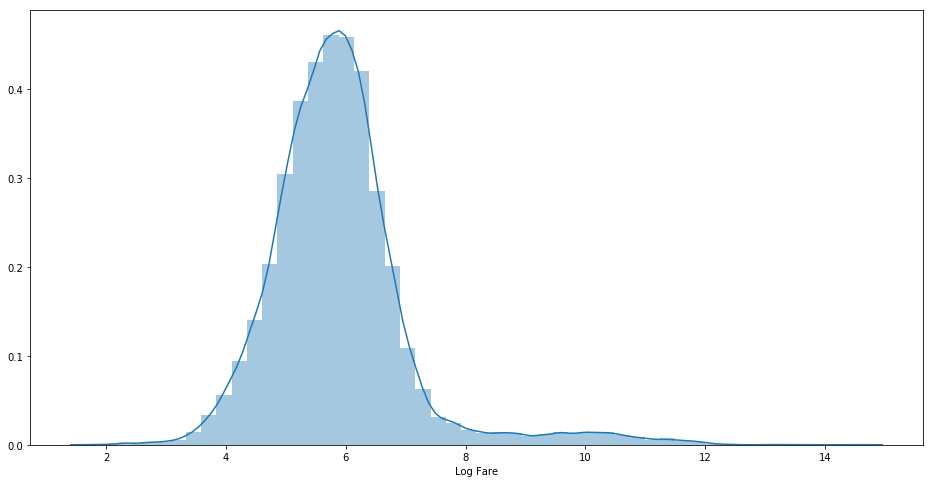

In [11]:
sns.distplot(np.log(flyr_data.bookings.fare), axlabel='Log Fare')

In [12]:
search_dedup = flyr_data.search.drop_duplicates()
booked_search = pd.merge(flyr_data.bookings, search_dedup, on=['session_id', 'itinerary_id'], how='inner', suffixes=['_booking', '_search'])
booked_search = booked_search[['search_id', 'fare_booking']].drop_duplicates(subset='search_id')
booked_search.columns = ['search_id', 'booked_fare']
search_with_outcome = pd.merge(search_dedup, booked_search, on=['search_id'], how='left')
search_with_outcome[search_with_outcome.booked_fare == search_with_outcome.fare].shape
search_with_outcome.loc[search_with_outcome.booked_fare.isna(), 'booked'] = False
search_with_outcome.loc[~search_with_outcome.booked_fare.isna(), 'booked'] = True
search_with_outcome = search_with_outcome[search_with_outcome.fare < 20000]
num_booked = search_with_outcome[search_with_outcome.booked].shape[0]
del search_with_outcome['booked_fare']
print('total number of True Positives is {}'.format(num_booked))

total number of True Positives is 15986


In [13]:
search_balanced = search_with_outcome[search_with_outcome.booked]
search_balanced = search_balanced.append(search_with_outcome[~search_with_outcome.booked].sample(num_booked))
searches = search_balanced
del search_balanced
del search_with_outcome
searches.shape

(31972, 26)

In [14]:
searches.head()

,search_id,search_time,currency,destination,search_user_id,language,origin,partner_id,passengers,pos,session_id,user_agent,num_requests,fare,supplier,cabin_class,carrier_1,carrier_2,flight_num_1,flight_num_2,departure_datetime_1,arrival_datetime_1,departure_datetime_2,arrival_datetime_2,itinerary_id,booked
2,c8903983-3eb9-4f0f-8f87-64b7e5dd0692,2017-02-01 00:00:39,USD,SJD,36195bda-ec40-4907-9428-c4fe11bd87fa,en,LAX,91,1,US,e0ae1ecd-8715-4577-bca4-604cf3a58d0e,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG-SM-...,1,286.79,91,economy,AA,AA,AA237,AA237,2017-05-30T08:35:00,2017-05-30T11:58:00,2017-06-03T13:00:00,2017-06-03T14:36:00,c53826cf-1fba-42a6-a765-941628e1901e,True
3,b1d666c8-d570-47ec-bc46-26ee5332620f,2017-02-01 00:00:48,USD,LHR,36ba8a8c-8c47-4dc6-bd70-0b3ae071c8cf,en,PHX,91,2,US,1eb74ec2-e6d7-4423-a1e3-de2a411a4aed,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,1,507.46,91,economy,DL; DL,DL; DL,DL5852; DL4414,DL11; DL1516,2017-05-10T13:13:00; 2017-05-10T18:30:00,2017-05-10T14:45:00; 2017-05-11T12:55:00,2017-05-28T12:55:00; 2017-05-28T17:50:00,2017-05-28T16:05:00; 2017-05-28T19:11:00,37a44686-8347-4c72-8690-c9432349f9a6,True
5,0abbfe4c-b72d-42c7-ae8a-966643e14600,2017-02-01 00:00:54,USD,LAX,025ee32b-2a0b-4987-b275-893f148ab259,en,CMH,91,1,US,262b200e-b183-48ab-b737-72c251ca0ff3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1...,1,192.20,91,economy,AA,NaN,AA659,NaN,2017-03-29T16:35:00,2017-03-29T18:53:00,NaN,NaN,2e3afcd8-7d56-4b49-a71b-f85c23e1b807,True
6,198f2d0f-4f30-418c-bf78-ccf776a63501,2017-02-01 00:01:02,USD,MCO,f69465d7-cdb2-4dd0-98ad-6362423a8dc3,en,EGE,91,1,US,97d78806-2f65-48af-9d21-e7f9bb6a667c,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,1,615.60,91,economy,UA; UA,UA; UA,UA4475; UA564,UA1191; UA1252,2017-02-10T07:52:00; 2017-02-10T11:00:00,2017-02-10T09:03:00; 2017-02-10T16:31:00,2017-02-13T08:47:00; 2017-02-13T11:40:00,2017-02-13T10:30:00; 2017-02-13T13:41:00,619b0f7c-825f-47b1-a191-300862feff80,True
8,bf0709c2-5775-48aa-952b-35f88430c431,2017-02-01 00:01:11,USD,PBI,7864485d-5c63-45ee-9e4d-a3c43e078b36,en,FLO,91,3,US,6619e1b4-7335-4ff3-9b9b-88bdc65ed715,Mozilla/5.0 (Linux; Android 6.0; RCT6513W87 Bu...,1,352.60,91,economy,AA; AA,AA; AA,AA4933; AA1846,AA539; AA4860,2017-05-26T05:25:00; 2017-05-26T07:40:00,2017-05-26T06:16:00; 2017-05-26T09:31:00,2017-05-28T08:25:00; 2017-05-28T13:00:00,2017-05-28T10:18:00; 2017-05-28T13:50:00,ead1e4c6-6d82-4aed-9d65-94e4b4d67ab0,True


In [15]:
search_features = SearchFeatures(searches, flyr_data.airport)

loading airport data...


../../src/features.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  self.airport = pd.concat([airport1, airport2]).drop_duplicates(subset=['iata_code'])


In [16]:
search_features.transform()

calculating number of stops...
extracting airline codes...
calculating travel distance...


../../src/features.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['flight_distance'][X.flight_distance.isna()] = X[~X.flight_distance.isna()].flight_distance.mean()


Parsing travel dates...
still parsing...
still parsing...
still parsing...
transforming features...
i have found 330 categorical and 4 numerical features.


In [17]:
search_features.x_and_y().head()

,origin,destination,currency,pos,cabin_class,partner_id,passengers,supplier,fare,stops_out,stops_in,AA,DL,UA,TP,B6,VY,SY,AC,AH,NK,AS,F9,BW,AF,HA,WS,G4,TK,BY,EK,FR,KL,VS,H1,JL,P9,U2,GA,LH,ST,KE,B2,4O,BE,WY,Z2,AM,D7,IB,NZ,BG,G8,UX,BA,D8,CM,SA,TB,OB,A3,AI,3M,W6,AV,NH,VX,WW,AY,PS,KQ,TT,TR,9K,EY,JQ,Y4,PR,BR,LX,TG,FI,QF,3O,SU,QR,IX,9W,LA,AZ,UP,AT,5J,CZ,CX,RJ,BT,SV,7I,EI,OK,MU,UL,ET,EQ,CI,AR,TS,VW,SN,AB,W4,WP,DD,FD,KU,SQ,7C,R7,MW,KA,TZ,VB,SG,SL,HQ,OD,UO,ZH,6E,XK,VN,OZ,EW,9V,AK,MS,SK,PF,MH,K6,CA,MN,4U,TO,UU,ZI,BL,OS,ME,QZ,VA,MK,V9,HM,LG,DY,V7,MT,3K,HV,ZB,SS,TU,PC,OU,QS,Q6,LO,0B,PD,IZ,LS,BV,2D,TN,VJ,GF,KK,7Y,MM,BI,KS,G3,S4,4B,RO,MF,JJ,PG,T5,OR,TX,FJ,LI,IT,EB,O6,9N,JY,WG,SJ,3S,E9,PZ,WM,CE,JP,BB,JU,DE,XY,LY,X3,SE,AD,FZ,J2,WE,7N,3E,W3,VZ,A5,PK,JT,FB,HX,XJ,TV,DG,QG,OM,XQ,BD,XX,7H,BC,8M,B7,BP,JE,NT,8I,FM,IG,5H,PY,UK,WX,G9,XL,SW,HG,NO,KX,QV,MD,HU,R3,TA,GK,TF,WN,TW,XW,9U,S3,LJ,EL,KM,EN,KC,PU,ZK,TI,PW,HY,PE,T3,4M,NX,SX,WB,BJ,FA,VC,WF,S7,I5,UG,F7,3U,NY,ID,GL,BM,1I,I2,VR,RQ,MI,U6,9X,SB,LR,PX,4D,XT,PM,OA,VT,TM,SP,KP,P0,YM,flight_distance,departure_out_month,departure_out_dow,departure_out_is_us_holidays,departure_out_is_fr_holidays,arrival_out_month,arrival_out_dow,arrival_out_is_us_holidays,arrival_out_is_fr_holidays,departure_in_month,departure_in_dow,departure_in_is_us_holidays,departure_in_is_fr_holidays,arrival_in_month,arrival_in_dow,arrival_in_is_us_holidays,arrival_in_is_fr_holidays,booked
2,LAX,SJD,USD,US,economy,91,1,91,286.79,1,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1468.102476,5.0,1.0,True,False,5.0,1.0,True,False,6.0,5.0,False,True,6.0,5.0,False,True,True
3,PHX,LHR,USD,US,economy,91,2,91,507.46,2,2,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [18]:
search_features.x_and_y().describe()

,passengers,fare,stops_out,stops_in,flight_distance
count,31972.000000,31972.000000,31972.000000,31972.000000,31972.000000
mean,1.651695,625.416887,1.703553,1.350181,3270.689661
std,1.088371,1332.726228,0.685609,0.899424,3115.489190
min,0.000000,0.000000,1.000000,0.000000,38.801346
25%,1.000000,229.482500,1.000000,1.000000,1293.676028
50%,1.000000,384.900000,2.000000,1.000000,2106.462665
75%,2.000000,611.670000,2.000000,2.000000,3774.882137
max,9.000000,19980.000000,4.000000,4.000000,19067.666651


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


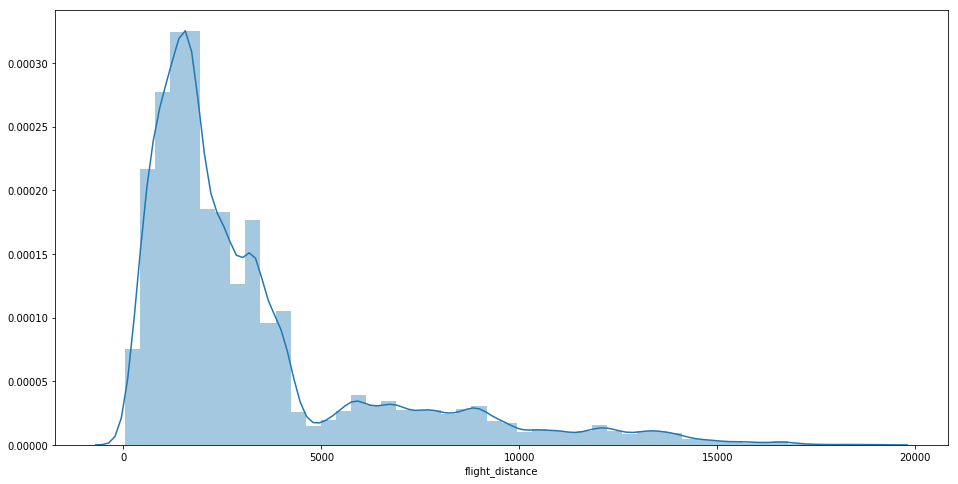

In [19]:
sns.distplot(search_features.x_and_y().flight_distance)